In [283]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

<AxesSubplot:xlabel='time'>

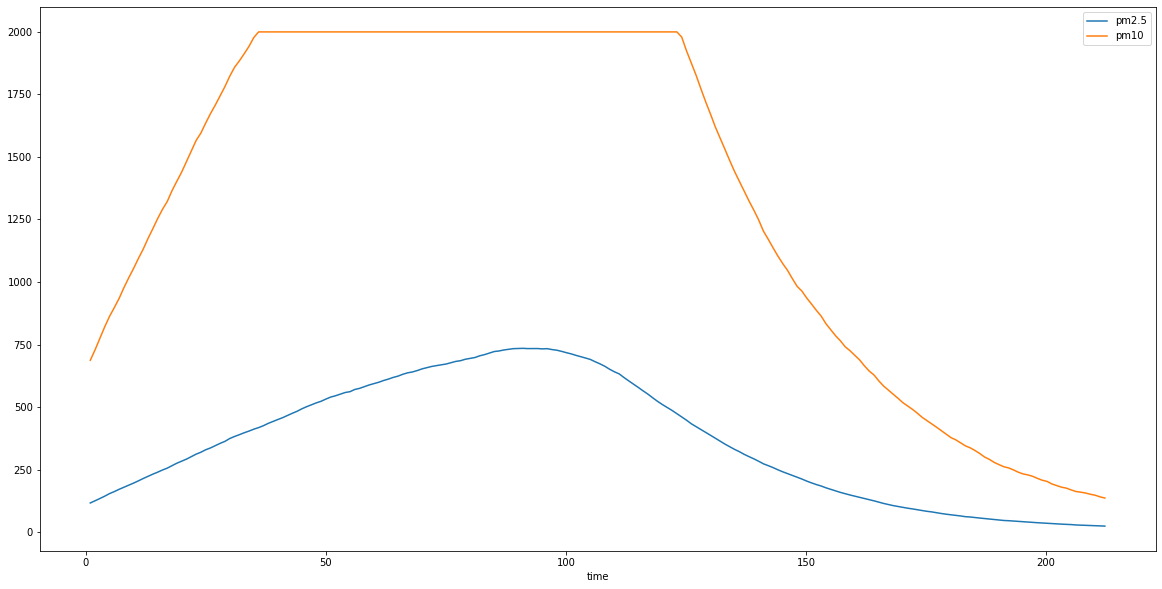

In [284]:
df = pd.read_csv('data_mesh/20220719_Levoit400s_4_spd.a.csv')
#df = pd.read_csv('data_mesh/20220719_ACH_vd.csv')

# plot the original data
df.set_index('time').plot(kind='line', figsize=(20,10))

In [285]:
del df['pm10']

df_low = df.copy()
df_low['pm2.5'] *= 0.85 # 15% low
df_high = df.copy()
df_high['pm2.5'] *= 1.15 # 15% high

In [286]:
# see equation (S1) from supplemental material here: https://www.tandfonline.com/doi/full/10.1080/02786826.2022.2054674?scroll=top&needAccess=true
# version of the functions where ACH is unknown and has to be solved for
class DecayFuncsACHUnk:
    def __init__(self, C_bgd, C_pt0):
        ## logarithmic function
        def func(t, ACH):
            # divide by 3600 to convert seconds to hours
            return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

        def linear_func(t, ACH):
            return np.log(C_pt0) - ACH * t / 3600

#        def linear_func(t, ACH, amp, omega, phi):
#            return np.log(C_pt0) - ACH * t / 3600 + amp * np.sin(omega * t + phi) + amp * np.cos(omega * t + phi)
        self.func = func
        self.linear_func = linear_func

# version of the functions where ACH is known and passed as a param
class DecayFuncsACH:
#    def __init__(self, C_bgd, C_pt0, ACH, amp, omega, phi):
    def __init__(self, C_bgd, C_pt0, ACH):
        ## logarithmic function
        def func(t):
            # divide by 3600 to convert seconds to hours
            return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

#        def func(t):
#            # divide by 3600 to convert seconds to hours
#            return C_bgd + C_pt0 * np.exp(-ACH*t / 3600) * np.exp(amp * np.sin(omega * t + phi)) * np.exp(amp * np.cos(omega * t + phi))


        def linear_func(t):
            return np.log(C_pt0) - ACH * t / 3600

#        def linear_func(t):
#            return np.log(C_pt0) - ACH * t / 3600 + amp * np.sin(omega * t + phi) + amp * np.cos(omega * t + phi)

        self.func = func
        self.linear_func = linear_func


In [287]:
# begin window search at pm2.5 max
pm25_max_idx = df.idxmax()['pm2.5']
if pm25_max_idx != 0:
    df = df.tail(-pm25_max_idx).copy()
df.index -= df.index[0]
df['time'] -= df.time[0]

# cut off all records before pm2.5 reached 500
drop_start_idx = df[df['pm2.5'] <= 500].index[0]
if drop_start_idx != 0:
    df = df.tail(-drop_start_idx).copy()
df.index -= df.index[0]
df['time'] -= df.time[0]

#print(df.index[0])
#print(df.head(1))
#print(df['pm2.5'][df.index[0]])
#print(df[df['pm2.5'] < 100].index[0])

# trim all values below 100, error stops being multiplicative below there
lt25_iloc = df[df['pm2.5'] < 100].index[0]
df = df.head(lt25_iloc).copy()

def test_fit(df):
    C_bgd = 0
    C_pt0 = df['pm2.5'][df.index[0]]
    f = DecayFuncsACHUnk(C_bgd, C_pt0)

    popt, pcov = curve_fit(f.linear_func, df.time, np.log(df['pm2.5']))
    stderr = np.sqrt(np.diag(pcov)[0])
    return (C_pt0, popt, stderr)

C_pt0, popt, stderr = test_fit(df)
ACH = popt[0]
print('C_pt0: {}'.format(C_pt0))
print('ACH: {}'.format(ACH))
print('stderr: {}'.format(stderr))

f = DecayFuncsACH(0, C_pt0, *popt)


C_pt0: 498.1
ACH_upper: 117.16732436513497, ACH_lower: 107.96485151573468, ACH: 113.52606011659562
stderr: 0.557798697588729


<AxesSubplot:xlabel='time'>

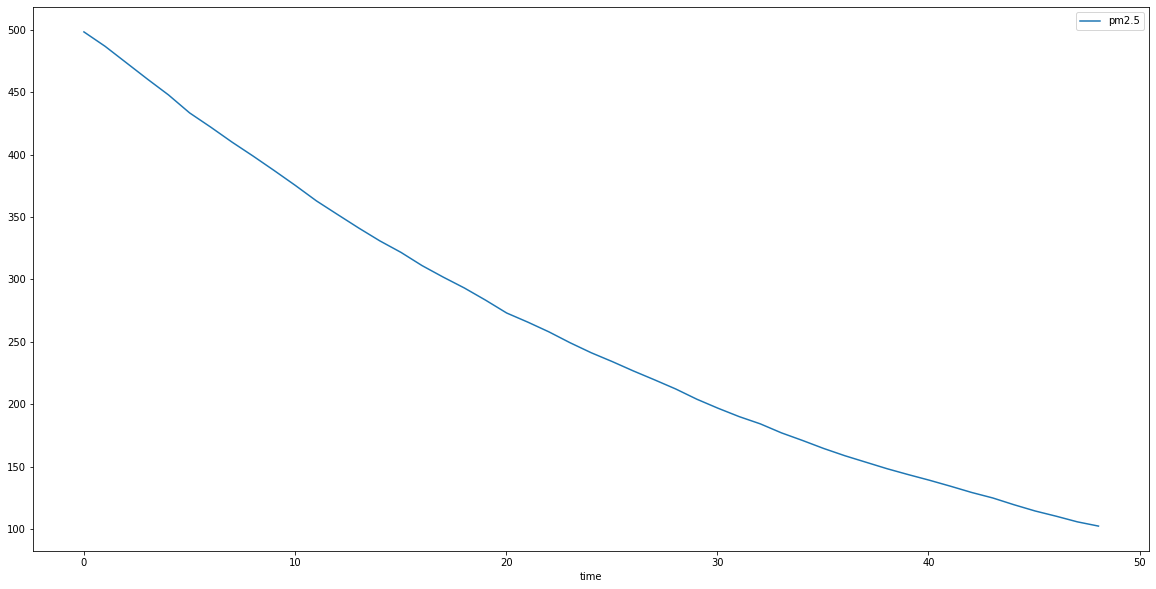

In [288]:
df.set_index('time').plot(kind='line', figsize=(20,10))

For this next part don't forget to change ACH_vd (ACH due to ventilation and deposition) and V_r (Volume of room/chamber) to match your values.

CADR_upper: 281.1899005157546, CADR_lower: 258.6970260792007
stderr: 0.557798697588729


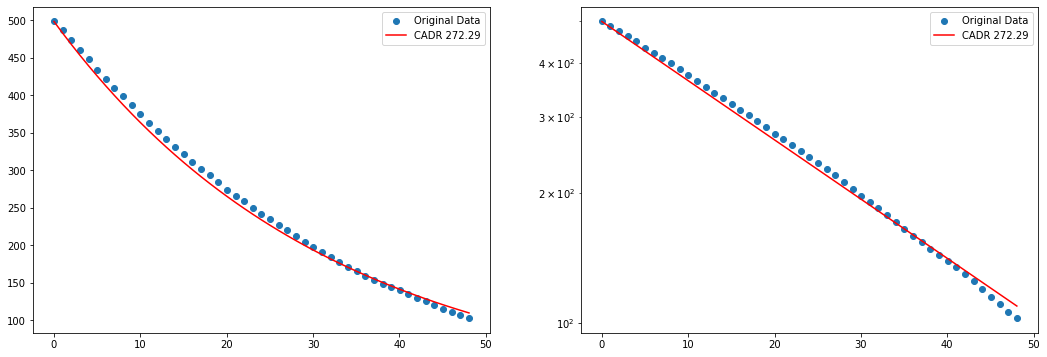

In [289]:
# Determine ACH_vd in trial with air cleaner off, it is ACH due to room ventilation (v) and particle deposition (d)
ACH_vd_jet = None
ACH_vd_mesh = 2.1245612749474594
ACH_vd_smoke = None
ACH_vd = ACH_vd_mesh
ACH_f = ACH - ACH_vd
# volume of room
V_r = (59. / 12) * (59. / 12) * (72.8 / 12) # this is in cubic feet
CADR = V_r * ACH_f / 60 # units of ACH are 1/h, divide by 60 to convert to 1/minutes so CADR is in cubic feet per minute
#CADR_upper = V_r * (ACH_upper - ACH_vd) / 60
#CADR_lower = V_r * (ACH_lower - ACH_vd) / 60
CADR_upper = V_r * (ACH_f + stderr) / 60
CADR_lower = V_r * (ACH_f - stderr) / 60


print('CADR_upper: {}, CADR_lower: {}'.format(CADR_upper, CADR_lower))
print('stderr: {}'.format(stderr))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

plt.subplot(121)
plt.scatter(df.time, df['pm2.5'], label="Original Data")
plt.plot(df.time, f.func(df.time), 'r-', label="CADR {:0.2f}".format(CADR))
plt.legend()

plt.subplot(122)
plt.scatter(df.time, df['pm2.5'], label="Original Data")
plt.plot(df.time, f.func(df.time), 'r-', label="CADR {:0.2f}".format(CADR))
plt.yscale('log')
plt.legend()
plt.show()